In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

import collections
import re

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tabulate
from IPython.display import HTML, display
from pymystem3 import Mystem

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [3]:
sns.set_style("whitegrid")

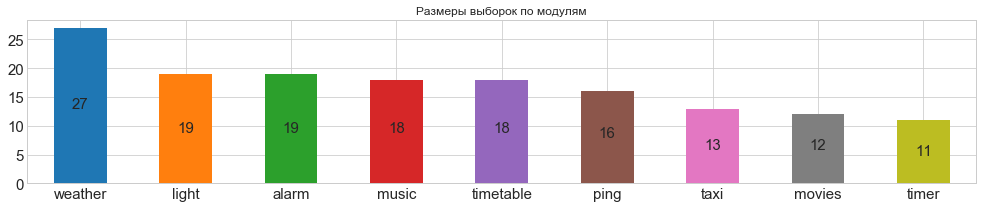

In [4]:
df = pd.read_csv('base_phrases.csv')
_, ax = plt.subplots(figsize=(17, 3))
ax = df.module.value_counts().plot(
    kind="bar",
    title='Размеры выборок по модулям',
    rot=0,
    fontsize=15,
    ax=ax
)
for bar in ax.patches:
    ax.text(
        bar.get_x()+.17,
        bar.get_height()//2,
        str(bar.get_height()),
        fontsize=15
    ) 

In [5]:
df_replaces = pd.read_csv('replaces.csv')
df_replaces

,replace,to_
0,понедельник|вторник|среда|четверг|пятница|субб...,<day_of_week>
1,позавчера|вчера|сегодня|завтра|послезавтра,<day>
2,\d+|один|два|три|четыре|пять|шеть|семь|восемь|...,<number>


In [6]:
def get_tag_map():
    url = ('https://raw.githubusercontent.com/akutuzov/'
           'universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/'
           'ru-rnc.map')
    
    m = {}
    r = requests.get(url, stream=True)
    for pair in r.text.split('\n'):
        pair = re.sub('\s+', ' ', pair, flags=re.U).split(' ')
        if len(pair) > 1:
            m[pair[0]] = pair[1]
    return m


def get_stop_words():
    with open('stopwords.txt', encoding='utf8') as f:
        return [x.replace('\n', '') for x in f if x]


mapping = get_tag_map()
stop_words = get_stop_words()
sentence_cache = {}
sentence_cache_pos = {}


def tag_mystem(text, pos=True):    
    if pos:
        if text in sentence_cache_pos:
            return sentence_cache_pos[text]
    else:
        if text in sentence_cache:
            return sentence_cache[text]  

    processed = Mystem().analyze(text)
    tagged = []
    for w in processed:
        try:
            # Стоп слова.
            if w["analysis"][0]["lex"] in stop_words:
                continue
                
            lemma = w["analysis"][0]["lex"].lower().strip()
            
            # Замена дней и чисел на токены.
            repaced_lemma = lemma
            for regex in df_replaces.values:
                repaced_lemma = re.sub(regex[0], regex[1], repaced_lemma)
            
            if repaced_lemma != lemma:
                tagged.append(repaced_lemma)
                continue
            
            # Если не нужна информация о части речи.
            if not pos:
                tagged.append(lemma)
                continue
                
            pos = w["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
            if pos in mapping:
                tagged.append(lemma + '_' + mapping[pos]) 
            else:
                tagged.append(lemma + '_X')
        except KeyError:
            continue

    if pos:
        sentence_cache_pos[text] = tagged
    else:
        sentence_cache[text] = tagged
        
    return tagged


tag_mystem('поставить будильник на понедельник в 12 часов', True)

['поставлять_VERB', 'будильник_NOUN', '<day_of_week>', 'час_NOUN']

In [7]:
class GensimW2VVectorizer():
    def __init__(self):
        self.model = gensim.models.KeyedVectors.load_word2vec_format(
            'araneum_upos_skipgram_300_2_2018.vec.gz', binary=False)
        self.model.init_sims(replace=True)
        self.dim = 300
        self.word2vec = dict(zip(self.model.index2word, self.model.vectors))
        
    def word_averaging(self, words):
        all_words, mean = set(), []
        for word in words:
            if isinstance(word, np.ndarray):
                mean.append(word)
            elif word in self.model.vocab:
                mean.append(self.model.vectors_norm[self.model.vocab[word].index])
                all_words.add(self.model.vocab[word].index)

        if not mean:
            import logging
            logging.warning("cannot compute similarity with no input %s", words)
            return np.zeros(self.dim,)

        mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
        # Plus ones for BernoulliNB, MultinomialNB.
        mean = np.sum([mean, np.ones(300)], axis=0)
        return mean

    def word_averaging_list(self, text_list):
        return np.vstack([self.word_averaging(review) for review in text_list ])

    def fit(self, x, y):
        return self

    def fit_transform(self, x):
        return self.word_averaging_list([tag_mystem(words, pos=True)
                                         for words in x])

In [8]:
vectorizers = {
    "№1": CountVectorizer(
        analyzer="word",
        tokenizer=tag_mystem,
        stop_words=stop_words,
    ),
    "№2": CountVectorizer(
        analyzer="word",
        tokenizer=tag_mystem,
        stop_words=stop_words,
        ngram_range=(2,5),
    ),
    "№3": CountVectorizer(
        analyzer="word",
        tokenizer=lambda x: tag_mystem(x, False),
        ngram_range=(2,5),
        stop_words=stop_words,
    ),
    "№4": CountVectorizer(
        analyzer="char",
        ngram_range=(2,5)
    ),
    "№5": CountVectorizer(
        analyzer="char",
        ngram_range=(2,5),
        tokenizer=lambda x: tag_mystem(x, False),
    ),
    "№6": TfidfVectorizer(
        tokenizer=tag_mystem,
        preprocessor=None,
        stop_words=stop_words
    ),
    "№7": TfidfVectorizer(
        tokenizer=lambda x: tag_mystem(x, False),
        preprocessor=None,
        stop_words=stop_words
    ),
    "№8": GensimW2VVectorizer(),
}

In [9]:
%%time
vectorized = {
    name: vectorizer.fit_transform(df['phrase'])
    for name, vectorizer in vectorizers.items()
}

Wall time: 6min


In [10]:
models = {
    "Метод опорных векторов": LinearSVC(),
    "Наивный Байесовский (Бернулли)": BernoulliNB(),
    "Наивный Байесовский (мультиномиальный)": MultinomialNB(),
    "Логистическая регрессия": LogisticRegression(random_state=0),
    "Метод k-ближайших соседей": KNeighborsClassifier(n_neighbors=3),
}

In [11]:
def display_cross_val_result_as_table(entries, k_fold):
    entries_dict = collections.defaultdict(list)
    for row in entries:
        entries_dict[row[0]].append(row[2])
    table = [[k, *v] + [sum(v)/k_fold] for k, v in entries_dict.items()]
    header = [
        "Векторизация",
        *[f"Валидация №{i+1}" for i in range(k_fold)],
        "Среднее значение"
    ]
    table.insert(0, header)

    display(HTML(tabulate.tabulate(
        table, headers="firstrow", tablefmt='html')))
    

def display_cross_val_result_as_barplot(title, entries):
    cv_df = pd.DataFrame(
        entries, columns=['Векторизация', 'Номер валидации', 'Точность'])

    _, ax = plt.subplots(figsize=(15, 4))
    sns.barplot(
        x='Точность',
        y='Векторизация',
        data=cv_df,
        ci=None
    ).set_title(title)
    
    ax = sns.stripplot(
        x='Точность',
        y='Векторизация',
        data=cv_df,
        jitter=True,
        edgecolor="gray",
        linewidth=1,
        ax=ax
    )
    ax.set_xlim([0, 1])
    plt.show()

    
def display_data_frame_as_heatmap(data_frame):
    f, ax = plt.subplots(figsize=(10, 10))
    ax.tick_params(labelsize=15)
    ax.set_xlabel("",fontsize=20)
    ax.set_ylabel("",fontsize=20)

    sns.heatmap(
        data_frame,
        ax=ax,
        fmt=".3f",
        annot=True,
        linewidths=1,
        vmin=0,
        vmax=1,
        cbar_kws={"orientation": "horizontal"},
        cmap='afmhot',
        center=0.5
    )

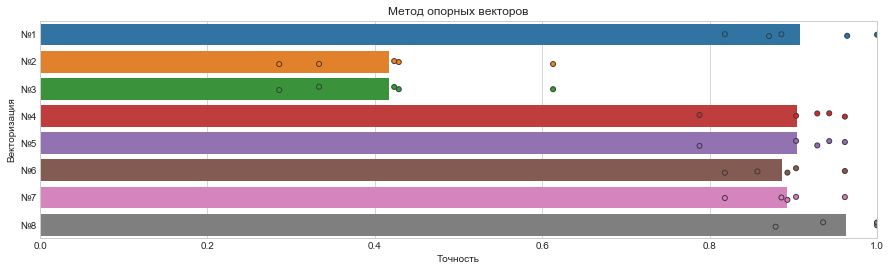

Векторизация,Валидация №1,Валидация №2,Валидация №3,Валидация №4,Валидация №5,Среднее значение
№1,0.885714,0.818182,0.870968,0.964286,1,0.90783
№2,0.428571,0.333333,0.612903,0.285714,0.423077,0.41672
№3,0.428571,0.333333,0.612903,0.285714,0.423077,0.41672
№4,0.942857,0.787879,0.903226,0.928571,0.961538,0.904814
№5,0.942857,0.787879,0.903226,0.928571,0.961538,0.904814
№6,0.857143,0.818182,0.903226,0.892857,0.961538,0.886589
№7,0.885714,0.818182,0.903226,0.892857,0.961538,0.892304
№8,1,0.878788,0.935484,1,1,0.962854


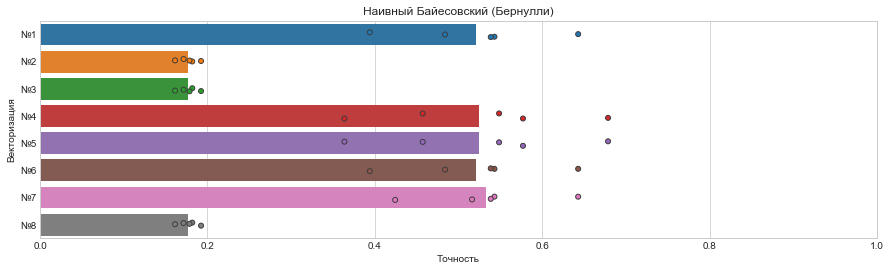

Векторизация,Валидация №1,Валидация №2,Валидация №3,Валидация №4,Валидация №5,Среднее значение
№1,0.542857,0.393939,0.483871,0.642857,0.538462,0.520397
№2,0.171429,0.181818,0.16129,0.178571,0.192308,0.177083
№3,0.171429,0.181818,0.16129,0.178571,0.192308,0.177083
№4,0.457143,0.363636,0.548387,0.678571,0.576923,0.524932
№5,0.457143,0.363636,0.548387,0.678571,0.576923,0.524932
№6,0.542857,0.393939,0.483871,0.642857,0.538462,0.520397
№7,0.542857,0.424242,0.516129,0.642857,0.538462,0.532909
№8,0.171429,0.181818,0.16129,0.178571,0.192308,0.177083


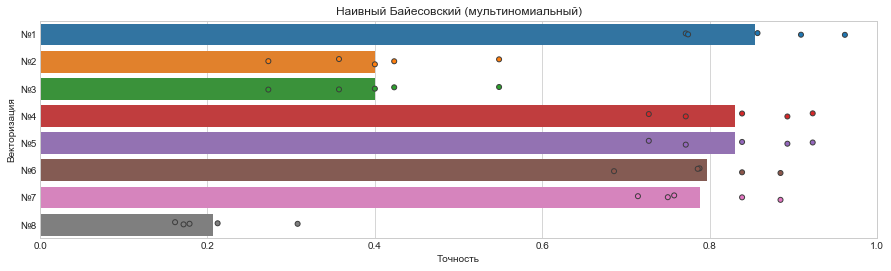

Векторизация,Валидация №1,Валидация №2,Валидация №3,Валидация №4,Валидация №5,Среднее значение
№1,0.771429,0.909091,0.774194,0.857143,0.961538,0.854679
№2,0.4,0.272727,0.548387,0.357143,0.423077,0.400267
№3,0.4,0.272727,0.548387,0.357143,0.423077,0.400267
№4,0.771429,0.727273,0.83871,0.892857,0.923077,0.830669
№5,0.771429,0.727273,0.83871,0.892857,0.923077,0.830669
№6,0.685714,0.787879,0.83871,0.785714,0.884615,0.796526
№7,0.714286,0.757576,0.83871,0.75,0.884615,0.789037
№8,0.171429,0.212121,0.16129,0.178571,0.307692,0.206221


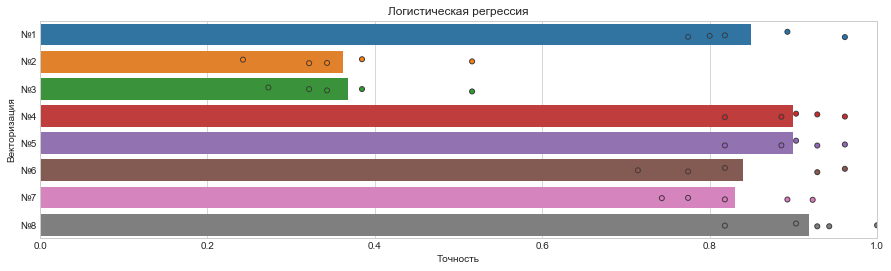

Векторизация,Валидация №1,Валидация №2,Валидация №3,Валидация №4,Валидация №5,Среднее значение
№1,0.8,0.818182,0.774194,0.892857,0.961538,0.849354
№2,0.342857,0.242424,0.516129,0.321429,0.384615,0.361491
№3,0.342857,0.272727,0.516129,0.321429,0.384615,0.367551
№4,0.885714,0.818182,0.903226,0.928571,0.961538,0.899446
№5,0.885714,0.818182,0.903226,0.928571,0.961538,0.899446
№6,0.714286,0.818182,0.774194,0.928571,0.961538,0.839354
№7,0.742857,0.818182,0.774194,0.892857,0.923077,0.830233
№8,0.942857,0.818182,0.903226,0.928571,1,0.918567


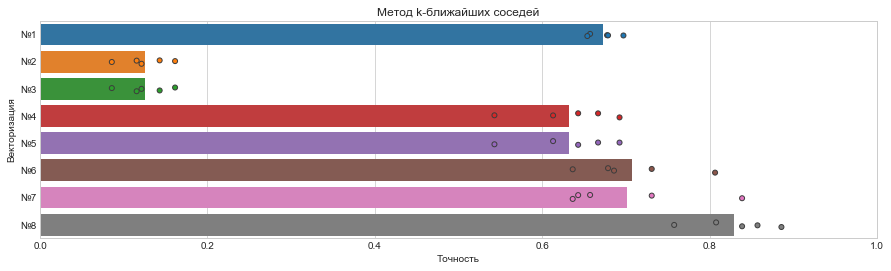

Векторизация,Валидация №1,Валидация №2,Валидация №3,Валидация №4,Валидация №5,Среднее значение
№1,0.657143,0.69697,0.677419,0.678571,0.653846,0.67279
№2,0.0857143,0.121212,0.16129,0.142857,0.115385,0.125292
№3,0.0857143,0.121212,0.16129,0.142857,0.115385,0.125292
№4,0.542857,0.666667,0.612903,0.642857,0.692308,0.631518
№5,0.542857,0.666667,0.612903,0.642857,0.692308,0.631518
№6,0.685714,0.636364,0.806452,0.678571,0.730769,0.707574
№7,0.657143,0.636364,0.83871,0.642857,0.730769,0.701169
№8,0.885714,0.757576,0.83871,0.857143,0.807692,0.829367


In [12]:
def fold_battleground():
    k_fold = 5
    
    for model_name, model in models.items():
        entries = []
        
        for vectorizer_name, x_train in vectorized.items():
            accuracies = cross_val_score(
                model,
                x_train,
                df['module'],
                scoring='accuracy',
                cv=k_fold
            )
            
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((vectorizer_name, fold_idx, accuracy))
        
        display_cross_val_result_as_barplot(model_name, entries)
        display_cross_val_result_as_table(entries, k_fold)


fold_battleground()

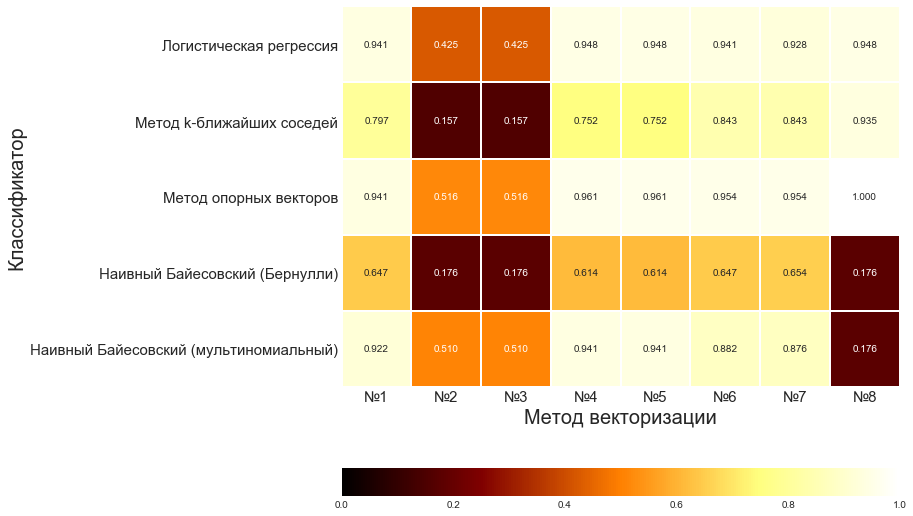

In [13]:
def leave_one_out_battleground():
    heat = []
    
    for model_name, model in models.items():
        for vectorizer_name, x_train in vectorized.items():
            accuracies = cross_val_score(
                model,
                x_train,
                df['module'],
                scoring='accuracy',
                cv=LeaveOneOut()
            )
            heat.append((
                model_name,
                vectorizer_name,
                sum(accuracies)/len(accuracies)
            ))
    
    cv_df = pd.DataFrame(
        heat,
        columns=['Классификатор', "Метод векторизации", "Точность"])
    d = cv_df.pivot("Классификатор", "Метод векторизации", "Точность")
    return d   


display_data_frame_as_heatmap(leave_one_out_battleground())